# Actividad M1
Edith Paulina Benvenuto Valerdi A00828840

Actividad donde se dan un numero de aspiradoras, el tamaño del tablero y el porcentaje de suciedad

Imports necesarios para correr el programa

In [1]:
!pip install mesa
# La clase `Model` se hace cargo de los atributos a nivel del modelo, maneja los agentes. 
# Cada modelo puede contener múltiples agentes y todos ellos son instancias de la clase `Agent`.
from mesa import Agent, Model 

# Debido a que necesitamos un solo agente por celda elegimos `SingleGrid` que fuerza un solo objeto por celda.
from mesa.space import MultiGrid
import math

# Con `SimultaneousActivation` hacemos que todos los agentes se activen de manera simultanea.
from mesa.time import SimultaneousActivation

# Vamos a hacer uso de `DataCollector` para obtener el grid completo cada paso (o generación) y lo usaremos para graficarlo.
from mesa.datacollection import DataCollector

# mathplotlib lo usamos para graficar/visualizar como evoluciona el autómata celular.
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
plt.rcParams["animation.html"] = "jshtml"
matplotlib.rcParams['animation.embed_limit'] = 2**128

# Definimos los siguientes paquetes para manejar valores númericos.
import numpy as np
import pandas as pd

# Definimos otros paquetes que vamos a usar para medir el tiempo de ejecución de nuestro algoritmo.
import time
import datetime

     |████████████████████████████████| 668 kB 3.9 MB/s 
     |████████████████████████████████| 63 kB 1.1 MB/s 


## Se crea el modelo



In [136]:
collisions = list()
def get_grid(model):
  grid = np.zeros((model.grid.width, model.grid.height))
  for cell in model.grid.coord_iter():
    cell_content, x,y = cell
    for content in cell_content:
      if isinstance(content, Cleaner):
        # Donde está la aspiradora
        grid[x][y] = 2
      else:
        # 0 / 1 dependiendo si esta limpio o sucio
        grid[x][y] = content.state
  return grid

class Floor(Agent):
  def __init__(self, unique_id, state,model):
    super().__init__(unique_id, model)
    # Estado limpio o sucio
    self.state=state

class Cleaner(Agent):
  def __init__(self, unique_id, pos, model):
    super().__init__(unique_id, model)
  
  def walk(self):
    
    posibleWalks = self.model.grid.get_neighborhood(self.pos, True, False)
    nextWalk = self.random.choice(posibleWalks)
    while nextWalk in collisions and self.model.generations>self.model.cleanersAux:
      posibleWalks = self.model.grid.get_neighborhood(self.pos, True, False)
      nextWalk = self.random.choice(posibleWalks)
    collisions.append(nextWalk)
    if self.pos in collisions:
      collisions.remove(self.pos)
    self.model.grid.move_agent(self, nextWalk)

  def step(self):
    thisCell = self.model.grid.get_cell_list_contents([self.pos])
    listFloor = [obj for obj in thisCell if isinstance(obj, Floor)]

    # maquina de estados
    if listFloor[0].state == 1: # agregar estado
      listFloor[0].state=0
      model.cleanedCells+=1
    else:
      self.walk()


class GridModel(Model):
  def __init__(self,M,N, cleaners, dirtyCells):
    self.cleanCells = cleaners
    self.dirtyCells = dirtyCells
    self.cleanedCells = 0
    self.generations =0
    self.cleanersAux= math.ceil(math.sqrt(cleaners))
    self.grid = MultiGrid(M,N,False)
    self.schedule = SimultaneousActivation(self)

    for i in range(dirtyCells):
      temp = Floor(i, 1, self)
      self.schedule.add(temp)
      emptyCell = self.grid.find_empty()
      self.grid.place_agent(temp, emptyCell)
      
    for i in range(cleanCells):
      temp = Floor(i+517,0,self)
      self.schedule.add(temp)
      emptyCell = self.grid.find_empty()
      self.grid.place_agent(temp, emptyCell)

    for i in range(cleaners):
      temp=Cleaner(i+1569, (0,0), self)
      self.schedule.add(temp)
      self.grid.place_agent(temp,(0,0))

    self.datacollector = DataCollector(
        model_reporters={"Grid": get_grid})

  def CLEAN(self):
    if self.dirtyCells == self.cleanedCells:
      return True
    else:
      return False        
    
  def step(self):
      self.datacollector.collect(self)
      self.schedule.step()
      self.generations +=1


Se corre el modelo con los parametros deseados:<br> M = Alto <br>N = Ancho<br>numCleaners = Numero de aspiradoras<br>porcDirtyCells = Porcentaje de celdas sucias <br> execTime = Tiempo de ejecución del programa

In [137]:
# Definimos el tamaño del Grid
M = 5
N = 5
numCleaners = 2
porcDirtyCells = 0.6
execTime = 0.1
cleanCells = int((N*M)-(N*M*porcDirtyCells))
dirtyCells = int(N*M*porcDirtyCells)

# Registramos el tiempo de inicio y corremos el modelo

model = GridModel(M,N,numCleaners,dirtyCells)
start_time = time.time()
while ((time.time() - start_time) < execTime and not model.CLEAN()): # que pasa si ya se limpio todo y aun tenemos tiempo
  model.step()

# Imprimimos el tiempo que le tomó correr al modelo.
print('Tiempo de ejecución:', str(datetime.timedelta(seconds=(time.time() - start_time))))
print("Porcentaje de celdas limpiadas: ", (model.cleanedCells/dirtyCells)*100,"%")
print("Numero de movimientos realizados por las aspiradoras: ", model.generations)


Tiempo de ejecución: 0:00:00.004312
Porcentaje de celdas limpias:  100.0 %
Numero de movimientos realizados por las aspiradoras:  56


Obtenemos la información que almacenó el colector, este nos entregará un DataFrame de pandas que contiene toda la información.

In [138]:
all_grid = model.datacollector.get_model_vars_dataframe()

Graficamos la información usando `matplotlib`

In [140]:
%%capture

fig, axs = plt.subplots(figsize=(7,7))
axs.set_xticks([])
axs.set_yticks([])
patch = plt.imshow(all_grid.iloc[0][0], cmap= 'Purples')

def animate(i):
    patch.set_data(all_grid.iloc[i][0])
    
anim = animation.FuncAnimation(fig, animate,frames = len(all_grid)) 

In [141]:
anim

Para esta actividad tenemos el número de celdas (MxN), el número de aspiradoras, el porcentaje del tablero que está sucio y el tiempo de ejecución del programa, dados estos valores, se crea de manera aleatoria las posiciones sucias en el tablero y las posiciones iniciales de las aspiradoras será siempre en la esquina superior izquierda.
Para este problema hay que tener claro la máquina de estados para cada agente, en el caso que el agente se encuentre en una casilla sucia, este debe limpiarla y posteriormente moverse de manera aleatoria a alguna de sus 8 posiciones vecinas. En el caso que el agente se encuentre en una posición limpia, solamente deberá moverse a una posición diferente a la actual. 

**Maquina de estados para cada agente**

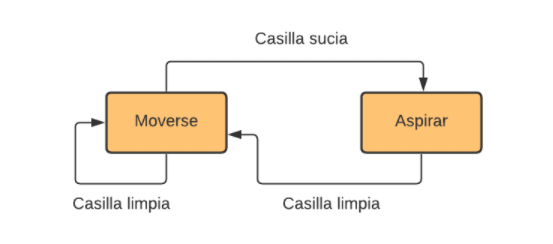

Uno de los problemas presentados cuando el agente desea moverse a una posición donde se encuentra otro agente, este permanecerá en su posición actual en esta iteración. 
Así mismo, si el tiempo de ejecución es mayor del que requiere el programa para realizar la limpieza del tablero, el programa terminará antes de terminar el tiempo de ejecución dado. En caso contrario que el tiempo de ejecución requerido para limpiar todo el tablero sea mayor al tiempo de ejecución brindado, el programa terminará antes y el porcentaje de celdas limpiadas será menor al 100%, ya que no se terminó el tiempo esperado para realizar la limpieza total.

**Conclusiones**

Uno de los mayores retos que se me presentaron en la realización del problema fue el movimiento de las aspiradoras a una posición donde ya se encuentra otra actualmente, ya que al comienzo mi logica fue condicionar que si se encontraba otra no realizará ningún movimiento, sin embargo, el la primera iteración todas se encuentran en la misma posición, por lo que ninguna realizaba ningún movimiento. Mi lógica final fue que dependiendo el número de aspiradoras, es el número de generaciones que ignorará esta condición, para que las aspiradoras puedan avanzar y tomar un lugar donde no haya otra en el mismo.

Este problema fue realmente útil tanto para familiarizarme con el entorno de desarrollo de mesa, conocer sus funcionalidades y adentrarme más en el manejo de multiagentes. El problema en sí no es de una complejidad muy grande, sin embargo, al tener un nivel muy básico en el dominio del tema fue un gran reto para mí.
